In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

/Users/baka_brooks/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_pickle('src/full_data_cleaned.pkl')
first = pd.read_pickle('src/individual_videos.pkl')

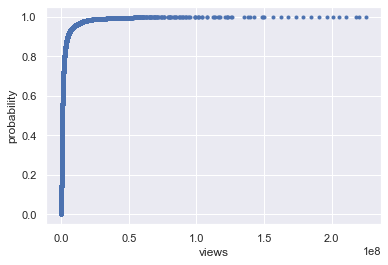

In [3]:
# plot ecdf of data
n = len(df.views)
x = np.sort(df.views)
y = np.arange(1, n+1) / n

plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('views')
plt.ylabel('probability');

Video views of trending videos are exponentially distributed

## Probability of a video to trend with under 100K views

In [4]:
mean_views = np.mean(df.views)

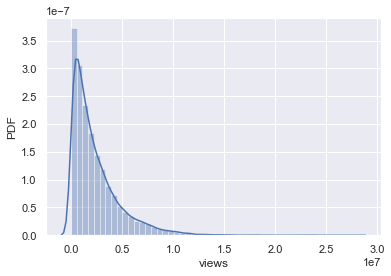

In [5]:
exp = np.random.exponential(mean_views, size=10000)

sns.distplot(exp)
plt.xlabel('views')
plt.ylabel('PDF');

In [6]:
prob = np.sum(exp <= 100000) / exp.size
print('Probability a trending will trend with under 100K views: ', prob)

Probability a trending will trend with under 100K views:  0.0395


## Bootstrap sample mean --> views
- Find the mean of views
- Calculate the confidence interval in the potential range of the mean

In [7]:
def samp_func(data, func):
    bs_samp = np.random.choice(data, len(data))
    return func(bs_samp)

In [8]:
size = 10000
bs_means = np.empty(size)

for i in range(bs_means.size):
    bs_means[i] = samp_func(df.views, np.mean)

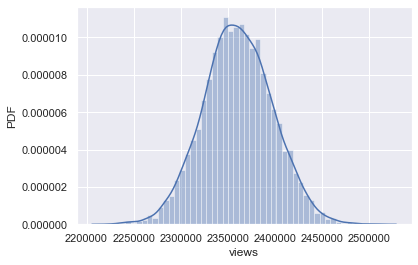

In [9]:
sns.distplot(bs_means, bins=50)
plt.xlabel('views')
plt.ylabel('PDF');

In [10]:
conf_int = np.percentile(bs_means, [2.5, 97.5])
print('The confidence interval of the average views of a trending video is: ', conf_int)

The confidence interval of the average views of a trending video is:  [2288999.18945625 2432792.57783184]


## Linear regression --> views x likes
- 95% CI, slope and intercept

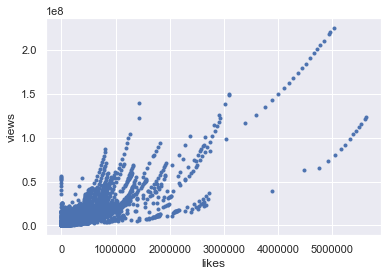

In [11]:
plt.plot(df.likes, df.views, marker='.', linestyle='none')
plt.xlabel('likes')
plt.ylabel('views');

In [12]:
ind = np.arange(len(df.views))

b_slopes = np.empty(1000)
b_intercepts = np.empty(1000)

for i in range(len(b_slopes)):
    b_samp = np.random.choice(ind, ind.size)
    b_likes = df.likes.iloc[b_samp]
    b_views = df.views.iloc[b_samp]
    samp_a, samp_b = np.polyfit(b_likes, b_views, 1)
    
    b_slopes[i] = samp_a
    b_intercepts[i] = samp_b

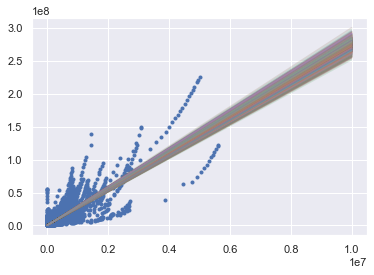

In [13]:
x = np.array([0, 10000000])

plt.plot(df.likes, df.views, marker='.', linestyle='none')

for i in range(len(b_slopes)):
    plt.plot(x, b_slopes[i]*x + b_intercepts[i], alpha=0.2)

In [14]:
conf_int_a = np.percentile(b_slopes, [2.5, 97.5])
conf_int_b = np.percentile(b_intercepts, [2.5, 97.5])

print('The confidence interval of the slope of the LLS regression is: ', conf_int_a)
print('The confidence interval of the intercept of the LLS regression is: ', conf_int_b)

The confidence interval of the slope of the LLS regression is:  [25.7773143  29.04308481]
The confidence interval of the intercept of the LLS regression is:  [223984.92755992 423228.13285838]


## Entertainment v. Music Trending Videos
Entertainment views v. music views

In [15]:
sorted(list(df.category.unique()))

['Autos & Vehicles',
 'Comedy',
 'Education',
 'Entertainment',
 'Film & Animation',
 'Gaming',
 'Howto & Style',
 'Music',
 'News & Politics',
 'Nonprofits & Activism',
 'People & Blogs',
 'Pets & Animals',
 'Science & Technology',
 'Shows',
 'Sports',
 'Travel & Events']

In [16]:
ent_views = df[df['category'] == 'Entertainment'].views
music_views = df[df['category'] == 'Music'].views

In [17]:
ent_views.size, music_views.size

(9944, 6467)

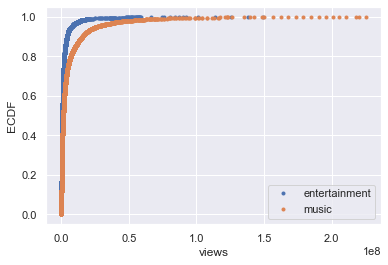

In [18]:
# entertainment ecdf
n_1 = ent_views.size
x_1 = np.sort(ent_views)
y_1 = np.arange(1, n_1+1) / n_1

plt.plot(x_1, y_1, marker='.', linestyle='none')

# music ecdf
n_2 = music_views.size
x_2 = np.sort(music_views)
y_2 = np.arange(1, n_2+1) / n_2

plt.plot(x_2, y_2, marker='.', linestyle='none')

# labels
plt.xlabel('views')
plt.ylabel('ECDF')
plt.legend(['entertainment', 'music']);

Entertainment and music content are exponentially distributed, but do not closely align.

### One-Sample Bootstrap
Using array of entertainment views, mean of music views

In [19]:
mean_views_music = np.mean(music_views)
mean_views_music

6204776.02304005

In [20]:
# translate the array based on the mean of the array and of the other group (meann views)
shifted_data = ent_views - np.mean(ent_views) + mean_views_music

In [21]:
# bootstrap the data, 10K simulations
b_samp = np.empty(10000)

for i in range(10000):
    boot = np.random.choice(shifted_data, shifted_data.size)
    b_samp[i] = np.mean(boot)

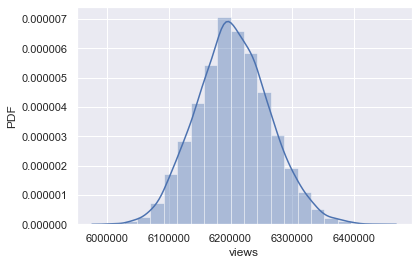

In [22]:
# plot the PDF
sns.distplot(b_samp, bins=20)
plt.xlabel('views')
plt.ylabel('PDF');

In [23]:
# calculate the p-value of bootstrap sample that is less than the mean entertainment views
p = np.sum(b_samp <= mean_views_music) / b_samp.size

print('P-value = ', p)

P-value =  0.5125


### Two-Sample Bootstrap

In [24]:
# translate both arrays
mean_views = np.mean(np.concatenate((ent_views, music_views)))

shifted_ent = ent_views - np.mean(ent_views) + mean_views
shifted_music = music_views - np.mean(music_views) + mean_views

In [26]:
# bootstrap both datasets, 10K simulations
bsamp_ent = np.empty(10000)
for i in range(10000):
    boot = np.random.choice(shifted_ent, shifted_ent.size)
    bsamp_ent[i] = np.mean(boot)
    
bsamp_music = np.empty(10000)
for it in range(10000):
    boot = np.random.choice(shifted_music, shifted_music.size)
    bsamp_music[i] = np.mean(boot)

In [40]:
# calculate the difference of means between the samples
bsamp_meandiffs = bsamp_ent - bsamp_music

In [42]:
# calculate the p-value
p = np.sum(bsamp_meandiffs >= (np.mean(ent_views) - np.mean(music_views))) / bsamp_meandiffs.size

print('P-value = ', p)

P-value =  1.0
